<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Анализ" data-toc-modified-id="Анализ-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Анализ</a></span></li><li><span><a href="#Обучение,тестирование" data-toc-modified-id="Обучение,тестирование-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Обучение,тестирование</a></span></li><li><span><a href="#Тестирование" data-toc-modified-id="Тестирование-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Тестирование</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

#  Прогнозирование заказов такси

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, нужно спрогнозировать количество заказов такси на следующий час. Постройте модель для такого предсказания.

Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

Вам нужно:

1. Загрузить данные и выполнить их ресемплирование по одному часу.
2. Проанализировать данные.
3. Обучить разные модели с различными гиперпараметрами. Сделать тестовую выборку размером 10% от исходных данных.
4. Проверить данные на тестовой выборке и сделать выводы.


Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце `num_orders` (от англ. *number of orders*, «число заказов»).

## Подготовка

In [1]:
# ипморт библиотек
import pandas as pd
from statsmodels.tsa.seasonal import seasonal_decompose
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.dummy import DummyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import TimeSeriesSplit # кросс-валидация для times series
from catboost import CatBoostRegressor
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

In [2]:
# загрузка и сохранение данных
taxi = pd.read_csv(r'C:\\dataset_praktikum/taxi.csv', index_col=[0], parse_dates=[0])

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.describe()

,num_orders
count,26496.000000
mean,14.070463
std,9.211330
min,0.000000
25%,8.000000
50%,13.000000
75%,19.000000
max,119.000000


In [5]:
taxi.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 26496 entries, 2018-03-01 00:00:00 to 2018-08-31 23:50:00
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype
---  ------      --------------  -----
 0   num_orders  26496 non-null  int64
dtypes: int64(1)
memory usage: 414.0 KB


In [6]:
#Проверим упорядочен ли наш index
print(taxi.index.is_monotonic)

True


In [7]:
taxi.reset_index().duplicated().sum() # проверка на дубликаты

0

<font color="blue">
Данные представлены в хорошем качестве. Дубликатов и пропущенных значений нет. Временной промежуток - 2018-03-01 00:00:00 to 2018-08-31 23:50:00, логи каждые десять минут.</font>

## Анализ

In [8]:
# Выполним ресемплирование данных по одному часу
taxi_h = taxi.resample('1H').sum()
# разложим данные и построим графики
decomposed_h = seasonal_decompose(taxi_h)

In [9]:
def plot_decomposed(df, decomposed):
    '''
    функция для построения графиков
    '''
    plt.figure(figsize=(13, 15))
    plt.subplot(411)
    df.plot(ax=plt.gca())
    plt.title('Orders_h (general)')
    plt.subplot(412)
    decomposed.trend.plot(ax=plt.gca())
    plt.title('Trend')
    plt.subplot(413)
    decomposed.seasonal.plot(ax=plt.gca())
    plt.title('Seasonality')
    plt.subplot(414)
    decomposed.resid.plot(ax=plt.gca())
    plt.title('Residuals')
    plt.tight_layout()

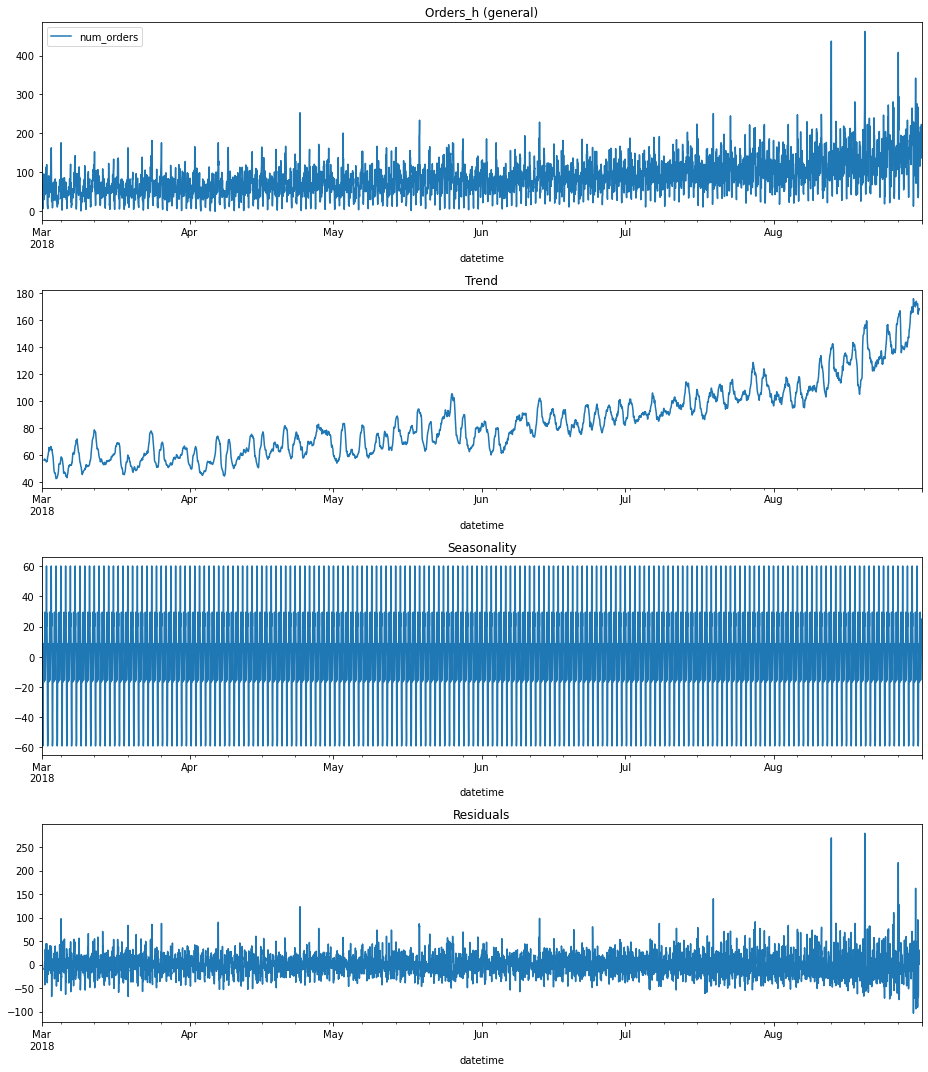

In [10]:
plot_decomposed(taxi_h, decomposed_h)

Присуствует сезонность, посмотрим поближе.

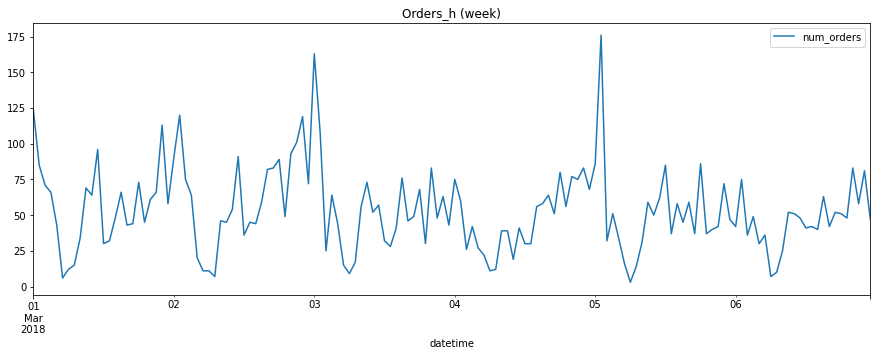

In [11]:
plt.figure(figsize=(15, 5))
taxi_h['2018-03-01':'2018-03-6'].plot(ax=plt.gca())
plt.title('Orders_h (week)')
plt.show()

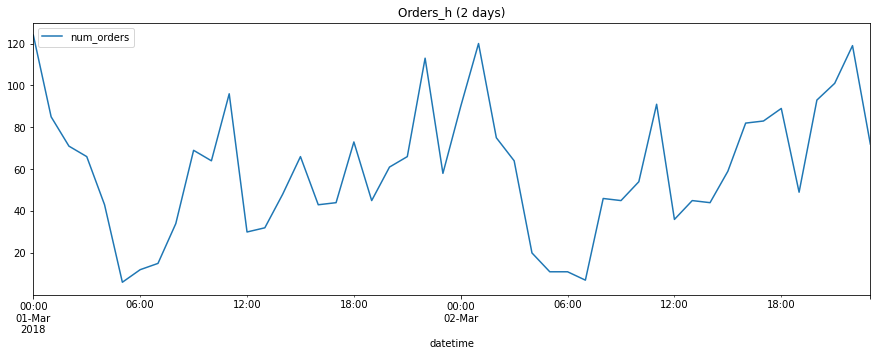

In [12]:
plt.figure(figsize=(15, 5))
taxi_h['2018-03-01':'2018-03-2'].plot(ax=plt.gca())
plt.title('Orders_h (2 days)')
plt.show()

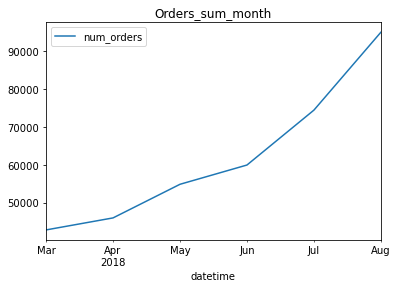

In [13]:
taxi.resample('1M').sum().plot(ax=plt.gca())
plt.title('Orders_sum_month')
plt.show()

<font color="blue">
 -число заказов увеличивается со временем (c марта по август число заказов такси выросло в три раза);
    
 -присутствует сезонность внутри дня (минимум заказов в 5 утра, далее количество заказов увеличивается до 12 дня, в обеденное время происходит небольшой спад и далее снова продолжается возрастание, основной пик приходится на полночь, далее резкий спад)</font>

In [14]:
# Выполним ресемплирование данных по одному часу
taxi_d = taxi.resample('1D').sum()
# разложим данные и построим графики
decomposed_d = seasonal_decompose(taxi_d)

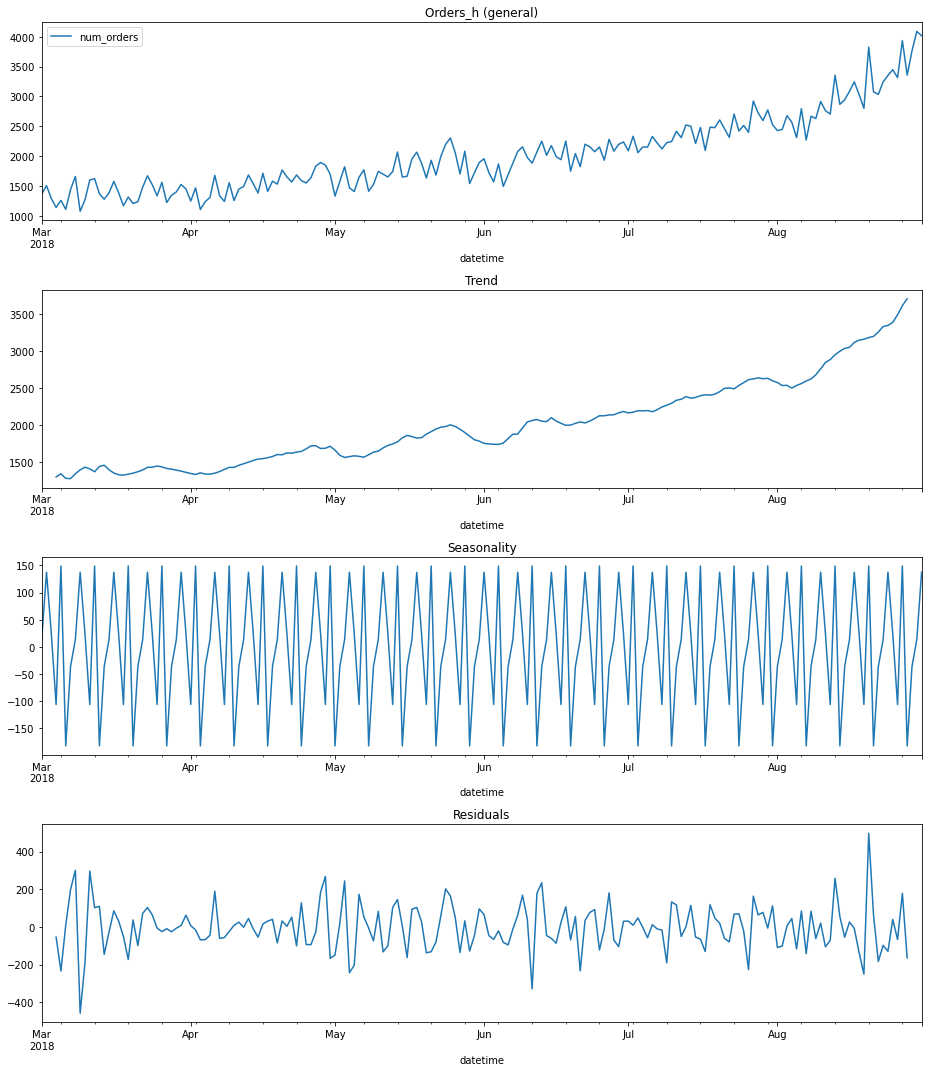

In [15]:
plot_decomposed(taxi_d, decomposed_d)

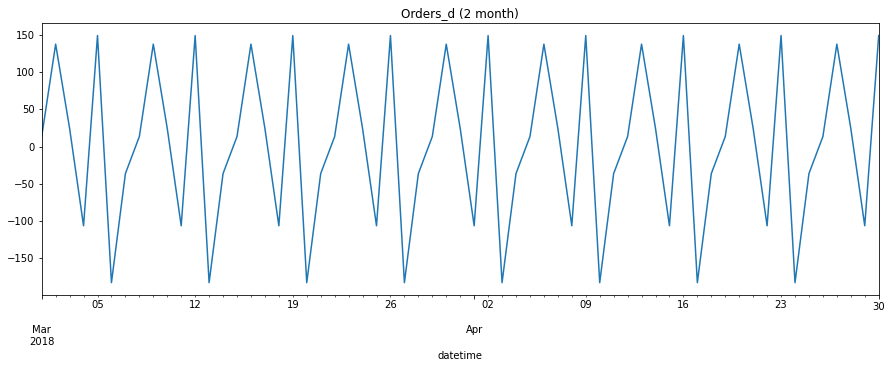

In [16]:
plt.figure(figsize=(15, 5))
#taxi_d['2018-03-01':'2018-04-30'].plot(ax=plt.gca())
decomposed_d.seasonal['2018-03-01':'2018-04-30'].plot(ax=plt.gca())
plt.title('Orders_d (2 month)')
plt.show()

<font color="blue">также есть сезонность по дням недели:
- меньше всего закзаов по вторникам и воскресеньям;
- больше заказов по понедельникам и пятницам.</font>

## Обучение,тестирование

**Добавим дополнительные признаки такие как месяц, день, час, сдвиги значений и скользящую среднюю. Разделим датасет на выборки, выделим признаки и целевую переменную.**

In [17]:
def make_features(df, max_lag, rolling_mean_size):
    data = df.copy()
    # создадим календарные признаки
    data['month'] = data.index.month
    data['day'] = data.index.day
    data['dayofweek'] = data.index.dayofweek
    data['hour'] = data.index.hour
    # добавим лаги
    for lag in range(1, max_lag + 1):
        data['lag_{}'.format(lag)] = data['num_orders'].shift(lag)
    # добавим cкользящее среднее
    data['rolling_mean'] = data['num_orders'].rolling(rolling_mean_size).mean()
    data['rolling_mean'] = data['rolling_mean'].shift()
    #Разобьем датасет на обучающую и тестовую выборки. Тестовую выборку сделаем размером 10% от исходных данных
    train, test = train_test_split(data, shuffle=False, test_size=0.1)
    train = train.dropna()
    #Выделим признаки и целевой признак
    y_train = train['num_orders']
    X_train = train.drop('num_orders', axis=1)
    y_test = test['num_orders']
    X_test = test.drop('num_orders', axis=1)
    
    return X_train, X_test, y_train, y_test

In [18]:
# исходные данные
X_train, X_test, y_train, y_test = make_features(taxi_h, 200, 10)

In [19]:
def metric_data(model, name):
    """
    Функция для обучения модели и подсчета метрик.
    На вход: модель, имя модели.
    Выход: датафрэйм с rmse_train, rmse_test.
    """
    model.fit(X_train, y_train)
    rmse_train = mean_squared_error(y_train, model.predict(X_train))**0.5
    rmse_test = mean_squared_error(y_test, model.predict(X_test))**0.5
    metric = pd.DataFrame({'rmse_train': rmse_train,
                            'rmse_test': rmse_test,
                           },
                               index=[name])
    return metric

**1. LinearRegression**

In [20]:
metric_lr = metric_data(LinearRegression(), 'lr')
metric_lr

,rmse_train,rmse_test
lr,20.085808,35.529754


**2. RandomForestRegressor**

In [21]:
metric_rf = metric_data(RandomForestRegressor(random_state=0, max_depth = 5), 'rf')
metric_rf

,rmse_train,rmse_test
rf,19.557185,41.732644


**3. CatBoost**

In [22]:
cv = TimeSeriesSplit(n_splits=3)

In [23]:
cbr = CatBoostRegressor(random_seed=0,
                        loss_function='RMSE',
                        silent=True)

params = {
    'learning_rate': np.logspace(-3, 0, 5),
    'iterations': [40, 60],
    'depth': [6, 8, 10],
}

grid_cbr = GridSearchCV(cbr,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=False)

In [24]:
grid_cbr.fit(X_train, y_train)

GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=<catboost.core.CatBoostRegressor object at 0x000001F7E52AD820>,
             param_grid={'depth': [6, 8, 10], 'iterations': [40, 60],
                         'learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ])},
             scoring='neg_mean_squared_error', verbose=False)

In [25]:
grid_cbr.best_params_

{'depth': 6, 'iterations': 60, 'learning_rate': 0.1778279410038923}

In [26]:
model_cbr = grid_cbr.best_estimator_

In [27]:
metric_cbr = metric_data(model_cbr, 'cbr')
metric_cbr

,rmse_train,rmse_test
cbr,17.543317,39.287691


**4. LightGBM**

In [28]:
lgbm = lgb.LGBMRegressor(boosting_type='gbdt', verbose=0, seed=0)

params = {
    'gbm__learning_rate': np.logspace(-3, 0, 5),
    'gbm__n_estimators': [40, 60],
    'gbm__num_leaves': [21, 31, 41],
}

grid_lgbm = GridSearchCV(lgbm,
                        params,
                        cv=cv,
                        scoring='neg_mean_squared_error',
                        verbose=True)

In [29]:
grid_lgbm.fit(X_train, y_train)

Fitting 3 folds for each of 30 candidates, totalling 90 fits
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007135 seconds.
You can set `force_col_wise=true` to remove the overhead.


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010139 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.010031 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006056 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006416 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.007877 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.011529 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006059 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009154 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006452 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008977 seconds.
You can set `force_col_wise=true` to

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.008445 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.006021 seconds.
You can set `force_col_wise=true` to

[Parallel(n_jobs=1)]: Done  90 out of  90 | elapsed:  1.2min finished


[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009897 seconds.
You can set `force_col_wise=true` to remove the overhead.


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
             estimator=LGBMRegressor(seed=0, verbose=0),
             param_grid={'gbm__learning_rate': array([0.001     , 0.00562341, 0.03162278, 0.17782794, 1.        ]),
                         'gbm__n_estimators': [40, 60],
                         'gbm__num_leaves': [21, 31, 41]},
             scoring='neg_mean_squared_error', verbose=True)

In [30]:
model_lgbm = grid_lgbm.best_estimator_

In [31]:
metric_lgbm = metric_data(model_lgbm, 'lgbm')
metric_lgbm

[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Unknown parameter: gbm__n_estimators
[LightGBM] [Warning] Unknown parameter: gbm__learning_rate
[LightGBM] [Warning] Unknown parameter: gbm__num_leaves
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.009901 seconds.
You can set `force_col_wise=true` to remove the overhead.


,rmse_train,rmse_test
lgbm,8.949242,37.024004


**5. Константная модель.**

Для проверки адекватности возьмем признак lag_1 (предшествующее значение целевого признака).

In [32]:
metric_const = pd.DataFrame({'rmse_train': mean_squared_error(y_train, X_train.lag_1)**0.5,
                            'rmse_test': mean_squared_error(y_test, X_test.lag_1)**0.5,
                           },
                               index=['const'])
metric_const

,rmse_train,rmse_test
const,36.414032,58.856486


In [33]:
metric = metric_lr.append(metric_rf).append(metric_cbr).append(metric_lgbm).append(metric_const)

In [34]:
metric.sort_values('rmse_test').style.background_gradient(subset=['rmse_test'], cmap='Purples')

,rmse_train,rmse_test
lr,20.085808,35.529754
lgbm,8.949242,37.024004
cbr,17.543317,39.287691
rf,19.557185,41.732644
const,36.414032,58.856486


<font color="blue">Все модели кроме константной справились с поставленной задачей - значение метрики RMSE на тестовой выборке меньше 48. Лучшей моделью оказалась LinearRegression (RMSE на тестовой выборке = 35,5)</font>

## Общий вывод

В данном проекте построена модель для прогнозирования количества заказов такси на следующий час.
Проанализированы несколько моделей. Лучший результат в эксперименте показала LinearRegression (rmse_test = 35,5).

Для обучения модели были созданы дополнительные признаки - календарные признаки, 200 лагов, cкользящее среднее с периодом 10.  

Также в ходе анализа данных сделаны следующие выводы: 
- число заказов увеличивается со временем (c марта по август число заказов такси выросло в три раза);
- присутствует сезонность внутри дня (минимум заказов в 5 утра, далее количество заказов увеличивается до 12 дня, в обеденное время происходит небольшой спад и далее снова продолжается возрастание, основной пик приходится на полночь, далее резкий спад);
- есть сезонность по дням недели:
    - меньше всего закзаов по вторникам и воскресеньям;
    - больше заказов по понедельникам и пятницам.